In [23]:
# --- Import Libraries ---
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [24]:
# TensorFlow / Keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf

In [25]:
import os

for dirpath, dirnames, filenames in os.walk('/content/stroke_dataset'):
    print(f"📁 Directory: {dirpath}")
    if dirnames:
        print(f"📂 Subdirs: {dirnames}")


📁 Directory: /content/stroke_dataset
📂 Subdirs: ['Stroke_classification']
📁 Directory: /content/stroke_dataset/Stroke_classification
📂 Subdirs: ['Ischemic', 'Haemorrhagic', 'Normal']
📁 Directory: /content/stroke_dataset/Stroke_classification/Ischemic
📁 Directory: /content/stroke_dataset/Stroke_classification/Haemorrhagic
📁 Directory: /content/stroke_dataset/Stroke_classification/Normal


In [26]:
data_path = '/content/stroke_dataset/Stroke_classification'


In [27]:
import zipfile

# Double-check the file path and file existence
file_path = '/content/Stroke_classification.zip'
if os.path.exists(file_path):
    print(f"File found at: {file_path}")
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall('/content/stroke_dataset')
else:
    print(f"⚠️ File not found at: {file_path}. Please re-upload or re-download.")

File found at: /content/Stroke_classification.zip


In [28]:
import zipfile

with zipfile.ZipFile('/content/Stroke_classification.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/stroke_dataset')


In [29]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# TensorFlow / Keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
import zipfile
# --- Data Loading Function ---
def load_data(base_path, categories, img_size=(224, 224), augment_minority=True):
    images = []
    labels = []

    datagen_aug = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        zoom_range=0.3,
        brightness_range=[0.5, 1.5],
        horizontal_flip=True,
        shear_range=0.3,
        fill_mode='nearest'
    )

    for label, category in enumerate(categories):
        category_path = os.path.join(base_path, category)
        if not os.path.exists(category_path):
            print(f"⚠️ Directory not found: {category_path}")
            continue

        category_images = []
        for img_file in os.listdir(category_path):
            img_path = os.path.join(category_path, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                category_images.append(img)

        category_images = np.array(category_images)

        if augment_minority and len(category_images) < 300:
            print(f"🔁 Augmenting class '{category}' with {len(category_images)} images")
            category_images = category_images.reshape((-1, img_size[0], img_size[1], 3))
            extra = 300 - len(category_images)
            aug_iter = datagen_aug.flow(category_images, batch_size=1)
            for _ in range(extra):
                aug_img = next(aug_iter)[0].astype(np.uint8)
                images.append(aug_img)
                labels.append(label)

        for img in category_images:
            images.append(img)
            labels.append(label)

    images = np.array(images)
    labels = to_categorical(labels, num_classes=len(categories))
    return images, labels
# --- Load Data ---
categories = ['Normal', 'Ischemic', 'Haemorrhagic']
data_path = '/content/stroke_dataset/Stroke_classification'
images, labels = load_data(data_path, categories) #Calling the load_data function to initialize the 'images' and 'labels' variables

# Optional: check class balance
labels_numeric = np.argmax(labels, axis=1)
print("Class distribution:", Counter(labels_numeric))

🔁 Augmenting class 'Ischemic' with 30 images
🔁 Augmenting class 'Haemorrhagic' with 186 images
Class distribution: Counter({np.int64(0): 399, np.int64(1): 300, np.int64(2): 300})


In [30]:
# Optional: check class balance
labels_numeric = np.argmax(labels, axis=1)
print("Class distribution:", Counter(labels_numeric))

Class distribution: Counter({np.int64(0): 399, np.int64(1): 300, np.int64(2): 300})


In [31]:
# --- Data Loading Function ---
def load_data(base_path, categories, img_size=(224, 224), augment_minority=True):
    images = []
    labels = []

    datagen_aug = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        zoom_range=0.3,
        brightness_range=[0.5, 1.5],
        horizontal_flip=True,
        shear_range=0.3,
        fill_mode='nearest'
    )

    for label, category in enumerate(categories):
        category_path = os.path.join(base_path, category)
        if not os.path.exists(category_path):
            print(f"⚠️ Directory not found: {category_path}")
            continue

        category_images = []
        for img_file in os.listdir(category_path):
            img_path = os.path.join(category_path, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                category_images.append(img)

        category_images = np.array(category_images)

        if augment_minority and len(category_images) < 300:
            print(f"🔁 Augmenting class '{category}' with {len(category_images)} images")
            category_images = category_images.reshape((-1, img_size[0], img_size[1], 3))
            extra = 300 - len(category_images)
            aug_iter = datagen_aug.flow(category_images, batch_size=1)
            for _ in range(extra):
                aug_img = next(aug_iter)[0].astype(np.uint8)
                images.append(aug_img)
                labels.append(label)

        for img in category_images:
            images.append(img)
            labels.append(label)

    images = np.array(images)
    labels = to_categorical(labels, num_classes=len(categories))
    return images, labels

In [32]:
# --- Load Data ---
categories = ['Normal', 'Ischemic', 'Haemorrhagic']
data_path = '/content/stroke_dataset/Stroke_classification'
images, labels = load_data(data_path, categories)

labels_numeric = np.argmax(labels, axis=1)
print("Class distribution:", Counter(labels_numeric))

🔁 Augmenting class 'Ischemic' with 30 images
🔁 Augmenting class 'Haemorrhagic' with 186 images
Class distribution: Counter({np.int64(0): 399, np.int64(1): 300, np.int64(2): 300})


In [33]:
# Optional: check class balance
labels_numeric = np.argmax(labels, axis=1)
print("Class distribution:", Counter(labels_numeric))

Class distribution: Counter({np.int64(0): 399, np.int64(1): 300, np.int64(2): 300})


In [34]:
# --- Split Data ---
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

In [35]:
# --- Data Augmentation ---
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    shear_range=0.2,
    fill_mode='nearest'
)
train_generator = datagen.flow(x_train, y_train, batch_size=32)

In [36]:
# --- Class Weights ---
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_numeric), y=labels_numeric)
class_weights = {i: w for i, w in enumerate(class_weights)}
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(0.8345864661654135), 1: np.float64(1.11), 2: np.float64(1.11)}


In [37]:
# --- Model ---
def build_model(input_shape=(224, 224, 3), num_classes=3):
    inputs = Input(shape=input_shape)
    base_model = EfficientNetB0(input_tensor=inputs, include_top=False, weights='imagenet')
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [38]:
# --- Callbacks ---
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)

In [39]:
# --- Train Model (initial) ---
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=(x_test, y_test),
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3525 - loss: 2.1084

25/25 ━━━━━━━━━━━━━━━━━━━━ 104s 4s/step - accuracy: 0.3538 - loss: 2.1012 - val_accuracy: 0.5600 - val_loss: 1.0111 - learning_rate: 1.0000e-04
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.4089 - loss: 1.7908 - val_accuracy: 0.5050 - val_loss: 0.9216 - learning_rate: 1.0000e-04
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.5476 - loss: 1.2642 - val_accuracy: 0.5300 - val_loss: 0.8629 - learning_rate: 1.0000e-04
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5672 - loss: 1.1129

25/25 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.5683 - loss: 1.1115 - val_accuracy: 0.5700 - val_loss: 0.8103 - learning_rate: 1.0000e-04
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5905 - loss: 1.0090

25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.5919 - loss: 1.0066 - val_accuracy: 0.6050 - val_loss: 0.7455 - learning_rate: 1.0000e-04
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6793 - loss: 0.8173

25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.6781 - loss: 0.8217 - val_accuracy: 0.6750 - val_loss: 0.6937 - learning_rate: 1.0000e-04
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6358 - loss: 0.9815

25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.6370 - loss: 0.9791 - val_accuracy: 0.6900 - val_loss: 0.6472 - learning_rate: 1.0000e-04
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6850 - loss: 0.8969

25/25 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.6844 - loss: 0.8971 - val_accuracy: 0.7500 - val_loss: 0.5617 - learning_rate: 1.0000e-04
Epoch 9/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6992 - loss: 0.7649

25/25 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.6992 - loss: 0.7641 - val_accuracy: 0.7900 - val_loss: 0.5038 - learning_rate: 1.0000e-04
Epoch 10/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7259 - loss: 0.8012

25/25 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.7258 - loss: 0.7999 - val_accuracy: 0.8050 - val_loss: 0.4638 - learning_rate: 1.0000e-04
Epoch 11/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7727 - loss: 0.6195

25/25 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.7718 - loss: 0.6215 - val_accuracy: 0.8650 - val_loss: 0.4007 - learning_rate: 1.0000e-04
Epoch 12/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.7502 - loss: 0.6885 - val_accuracy: 0.8500 - val_loss: 0.3911 - learning_rate: 1.0000e-04
Epoch 13/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7483 - loss: 0.6545

25/25 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.7480 - loss: 0.6558 - val_accuracy: 0.8750 - val_loss: 0.3615 - learning_rate: 1.0000e-04
Epoch 14/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.7684 - loss: 0.5855 - val_accuracy: 0.8700 - val_loss: 0.3490 - learning_rate: 1.0000e-04
Epoch 15/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.7726 - loss: 0.5660 - val_accuracy: 0.8700 - val_loss: 0.3518 - learning_rate: 1.0000e-04
Epoch 16/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7773 - loss: 0.6086

25/25 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step - accuracy: 0.7774 - loss: 0.6088 - val_accuracy: 0.8850 - val_loss: 0.3062 - learning_rate: 1.0000e-04
Epoch 17/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7900 - loss: 0.5455

25/25 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.7897 - loss: 0.5460 - val_accuracy: 0.9050 - val_loss: 0.2842 - learning_rate: 1.0000e-04
Epoch 18/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7818 - loss: 0.6170

25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.7817 - loss: 0.6161 - val_accuracy: 0.9150 - val_loss: 0.2751 - learning_rate: 1.0000e-04
Epoch 19/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - accuracy: 0.8322 - loss: 0.4484 - val_accuracy: 0.9150 - val_loss: 0.2629 - learning_rate: 1.0000e-04
Epoch 20/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.7879 - loss: 0.5264 - val_accuracy: 0.9050 - val_loss: 0.2747 - learning_rate: 1.0000e-04
Epoch 21/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.7850 - loss: 0.5725 - val_accuracy: 0.8900 - val_loss: 0.2869 - learning_rate: 1.0000e-04
Epoch 22/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.7787 - loss: 0.5511 - val_accuracy: 0.8750 - val_loss: 0.2910 - learning_rate: 1.0000e-04
Epoch 23/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.8176 - loss: 0.4630 - val_accuracy: 0.8850 - val_loss: 0.2809 - learning_rate: 2.0000e-05
Epoch 24/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.8435 - loss: 0.39

In [40]:
# --- Fine-tune EfficientNet ---
model.load_weights('best_model.h5')
model.get_layer(index=1).trainable = True  # Unfreeze EfficientNet
for layer in model.layers[-40:]:  # fine-tune last 40 layers
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
# --- Train Model (fine-tuning) ---
fine_tune_history = model.fit(
    train_generator,
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 114s 4s/step - accuracy: 0.7661 - loss: 0.6461 - val_accuracy: 0.9050 - val_loss: 0.2655 - learning_rate: 1.0000e-05
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.7816 - loss: 0.5993 - val_accuracy: 0.8950 - val_loss: 0.2648 - learning_rate: 1.0000e-05
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.8061 - loss: 0.5148 - val_accuracy: 0.9100 - val_loss: 0.2501 - learning_rate: 1.0000e-05
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.7855 - loss: 0.5484 - val_accuracy: 0.9150 - val_loss: 0.2388 - learning_rate: 1.0000e-05
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.8091 - loss: 0.4835 - val_accuracy: 0.9200 - val_loss: 0.2313 - learning_rate: 1.0000e-05
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - accuracy: 0.7987 - loss: 0.5301 - val_accuracy: 0.9000 - val_loss: 0.2415 - learning_rate: 1.0000e-05
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - accuracy: 0.8075 - loss

7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
              precision    recall  f1-score   support

      Normal       0.85      0.97      0.91        80
    Ischemic       0.98      0.98      0.98        60
Haemorrhagic       0.96      0.77      0.85        60

    accuracy                           0.92       200
   macro avg       0.93      0.91      0.91       200
weighted avg       0.92      0.92      0.91       200



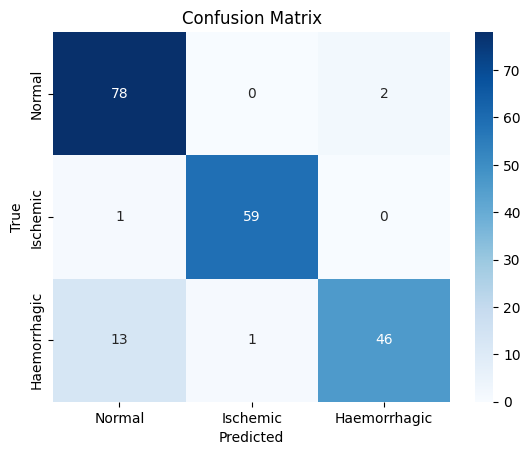

In [42]:
# --- Evaluate Model ---
model.load_weights('best_model.h5')
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=categories))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [52]:
!ngrok config add-authtoken 2wU4psaBXwKw5LS06iBIcETQAri_3Y8RFY6wiv4iMgGC5Rut3


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [61]:
!pip install streamlit
!pip install pyngrok
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.3 MB/s eta 0:00:00


In [66]:
!pip install fpdf


  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=2d9b03e053e14ccc712a85e22bffb98d70e6e5edac9ad4021310c2d5a33deb0a
  Stored in directory: /root/.cache/pip/wheels/65/4f/66/bbda9866da446a72e206d6484cd97381cbc7859a7068541c36
Successfully built fpdf


In [70]:
import gradio as gr
import numpy as np
from PIL import Image
import datetime
import cv2
import io
from fpdf import FPDF
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load your trained model and categories
from tensorflow.keras.models import load_model
model = load_model("best_model.h5")  # replace with your actual model file path
categories = ["No Stroke", "Ischemic", "Hemorrhagic"]  # adjust based on your trained labels

# Function to create PDF from text
def generate_pdf(report_text):
    pdf = FPDF()
    pdf.add_page()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.set_font("Arial", size=12)

    for line in report_text.split("\n"):
        pdf.multi_cell(0, 10, line)

    pdf_output = io.BytesIO()
    pdf_bytes = pdf.output(dest='S').encode('latin-1')
    pdf_output.write(pdf_bytes)
    pdf_output.seek(0)
    return pdf_output

# Actual prediction function
def predict(image, name, gender, scan_type):
    if scan_type != "MRI":
        return "Coming Soon", "N/A", "N/A", "CT prediction not supported yet.", None

    # Convert PIL to OpenCV format
    img = np.array(image)
    img = cv2.resize(img, (224, 224))
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    pred_class = np.argmax(prediction)
    confidence = np.max(prediction)

    result = "Stroke Detected" if pred_class != 0 else "No Stroke"
    stroke_type = categories[pred_class] if pred_class != 0 else "None"

    # Generate report
    now = datetime.datetime.now()
    report = f"""
    Stroke Sense – AI Stroke Detection Report
    Date: {now.strftime('%Y-%m-%d %H:%M:%S')}

    Patient Name: {name or 'N/A'}
    Gender: {gender}
    Scan Type: {scan_type}

    Diagnosis: {result}
    Stroke Type: {stroke_type}
    Confidence: {confidence * 100:.2f}%

    Summary:
    The uploaded {scan_type} scan shows radiological features indicating a {stroke_type.lower()} stroke.
    Further medical consultation is advised.

    This report was generated automatically by Stroke Sense.
    """

    pdf_file = generate_pdf(report)
    return result, stroke_type, f"{confidence*100:.2f}%", report, ("stroke_report.pdf", pdf_file)

# Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=[
        gr.Image(type="pil"),
        gr.Textbox(label="Patient Name"),
        gr.Radio(choices=["Male", "Female", "Other"], label="Gender"),
        gr.Radio(choices=["MRI", "CT (Coming Soon)"], label="Scan Type")
    ],
    outputs=[
        gr.Textbox(label="Diagnosis Result"),
        gr.Textbox(label="Stroke Type"),
        gr.Textbox(label="Model Confidence"),
        gr.Textbox(label="Generated Report", lines=10),
        gr.File(label="Download PDF Report")
    ],
    title="Stroke Sense – AI Stroke Detection",
    description="Upload a brain scan and enter patient info to generate a medical diagnosis report using AI."
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://08b3dcb195382796c2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [63]:
import gradio as gr
import numpy as np
from PIL import Image
import datetime
import cv2
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load your trained model and categories
from tensorflow.keras.models import load_model
model = load_model("best_model.h5")  # replace with your actual model file path
categories = ["No Stroke", "Ischemic", "Hemorrhagic"]  # adjust based on your trained labels

# Actual prediction function
def predict(image, name, gender, scan_type):
    if scan_type != "MRI":
        return "Coming Soon", "N/A", "N/A", "CT prediction not supported yet."

    # Convert PIL to OpenCV format
    img = np.array(image)
    img = cv2.resize(img, (224, 224))
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    pred_class = np.argmax(prediction)
    confidence = np.max(prediction)

    result = "Stroke Detected" if pred_class != 0 else "No Stroke"
    stroke_type = categories[pred_class] if pred_class != 0 else "None"

    # Generate report
    now = datetime.datetime.now()
    report = f"""
    Stroke Sense – AI Stroke Detection Report
    Date: {now.strftime('%Y-%m-%d %H:%M:%S')}

    Patient Name: {name or 'N/A'}
    Gender: {gender}
    Scan Type: {scan_type}

    Diagnosis: {result}
    Stroke Type: {stroke_type}
    Confidence: {confidence * 100:.2f}%

    Summary:
    The uploaded {scan_type} scan shows radiological features indicating a {stroke_type.lower()} stroke.
    Further medical consultation is advised.

    This report was generated automatically by Stroke Sense.
    """

    return result, stroke_type, f"{confidence*100:.2f}%", report

# Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=[
        gr.Image(type="pil"),
        gr.Textbox(label="Patient Name"),
        gr.Radio(choices=["Male", "Female", "Other"], label="Gender"),
        gr.Radio(choices=["MRI", "CT (Coming Soon)"], label="Scan Type")
    ],
    outputs=[
        gr.Textbox(label="Diagnosis Result"),
        gr.Textbox(label="Stroke Type"),
        gr.Textbox(label="Model Confidence"),
        gr.Textbox(label="Generated Report", lines=10)
    ],
    title="Stroke Sense – AI Stroke Detection",
    description="Upload a brain scan and enter patient info to generate a medical diagnosis report using AI."
)

interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://adb15a5dcc0c1061a7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [62]:
import gradio as gr
import numpy as np
from PIL import Image
import datetime

# Dummy model for demonstration purposes (replace with actual model prediction logic)
def predict(image, name, gender, scan_type):
    # Simulate prediction output
    result = "Stroke Detected"
    stroke_type = "Ischemic"
    confidence = 0.89

    # Generate report
    now = datetime.datetime.now()
    report = f"""
    Stroke Sense – AI Stroke Detection Report
    Date: {now.strftime('%Y-%m-%d %H:%M:%S')}

    Patient Name: {name or 'N/A'}
    Gender: {gender}
    Scan Type: {scan_type}

    Diagnosis: {result}
    Stroke Type: {stroke_type}
    Confidence: {confidence * 100:.2f}%

    Summary:
    The uploaded {scan_type} scan shows radiological features indicating a {stroke_type.lower()} stroke.
    Further medical consultation is advised.

    This report was generated automatically by Stroke Sense.
    """

    return result, stroke_type, f"{confidence*100:.2f}%", report

# Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=[
        gr.Image(type="pil"),
        gr.Textbox(label="Patient Name"),
        gr.Radio(choices=["Male", "Female", "Other"], label="Gender"),
        gr.Radio(choices=["MRI", "CT (Coming Soon)"], label="Scan Type")
    ],
    outputs=[
        gr.Textbox(label="Diagnosis Result"),
        gr.Textbox(label="Stroke Type"),
        gr.Textbox(label="Model Confidence"),
        gr.Textbox(label="Generated Report", lines=10)
    ],
    title="Stroke Sense – AI Stroke Detection",
    description="Upload a brain scan and enter patient info to generate a medical diagnosis report using AI."
)

interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5fed6bc07614b004f3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [54]:
import streamlit as st
import numpy as np
from PIL import Image
import datetime

# Dummy prediction function (replace with your actual model call)
def predict_stroke(image_array):
    # Example dummy result
    return {
        "result": "Stroke Detected",
        "type": "Ischemic",
        "confidence": 0.897
    }

# Title
st.title("Stroke Sense – AI Stroke Detection")

# Sidebar user info
st.sidebar.header("Patient Information")
patient_name = st.sidebar.text_input("Name")
patient_gender = st.sidebar.selectbox("Gender", ["Male", "Female", "Other"])
scan_type = st.sidebar.selectbox("Scan Type", ["MRI", "CT (Coming Soon)"])
uploaded_image = st.file_uploader("Upload MRI Image", type=["jpg", "jpeg", "png"])

# Prediction and report section
if uploaded_image and scan_type == "MRI":
    image = Image.open(uploaded_image).convert("RGB")
    st.image(image, caption="Uploaded MRI Image", use_column_width=True)

    # Convert image to array (resize & preprocess as needed)
    image_array = np.array(image.resize((224, 224))) / 255.0

    # Predict
    result = predict_stroke(image_array)

    st.subheader("Prediction Result")
    st.write(f"**Result:** {result['result']}")
    st.write(f"**Stroke Type:** {result['type']}")
    st.write(f"**Confidence:** {result['confidence'] * 100:.2f}%")

    # Generate report
    st.subheader("Generated Medical Report")
    now = datetime.datetime.now()
    report_text = f"""
    Stroke Sense – AI Stroke Detection System Report
    Date: {now.strftime('%Y-%m-%d %H:%M:%S')}

    Patient Name: {patient_name or 'N/A'}
    Gender: {patient_gender}
    Scan Type: {scan_type}

    Diagnosis: {result['result']}
    Stroke Type: {result['type']}
    Confidence: {result['confidence'] * 100:.2f}%

    Summary:
    The uploaded {scan_type} scan indicates radiological signs consistent with a {result['type'].lower()} stroke.
    Further clinical assessment is advised.

    This report was generated automatically by Stroke Sense – AI-Powered Detection System.
    """
    st.text_area("Medical Report", report_text, height=300)

    # Downloadable report (optional future)
    # st.download_button("Download Report", report_text, file_name="stroke_report.txt")

elif uploaded_image and scan_type == "CT (Coming Soon)":
    st.warning("CT scan analysis is currently under development. Please use an MRI image.")


2025-05-01 07:12:05.865 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-01 07:12:05.868 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-01 07:12:05.872 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-01 07:12:05.874 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-01 07:12:05.877 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-01 07:12:05.883 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-01 07:12:05.886 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-01 07:12:05.888 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [59]:
from pyngrok import ngrok
conf.get_default().auth_token = "2wU4psaBXwKw5LS06iBIcETQAri_3Y8RFY6wiv4iMgGC5Rut3"
# Specify the tunnel configuration with 'addr' for HTTP tunnels
public_url = ngrok.connect(addr=8501)
print(f"✅ Open your Streamlit app here: {public_url}")

✅ Open your Streamlit app here: NgrokTunnel: "https://92ce-34-83-197-98.ngrok-free.app" -> "http://localhost:8501"


In [50]:
from pyngrok import conf, ngrok

# ربط التوكن
conf.get_default().auth_token = "2wU4psaBXwKw5LS06iBIcETQAri_3Y8RFY6wiv4iMgGC5Rut3"

# فتح نفق على بورت 8501 (حق Streamlit)
public_url = ngrok.connect(port=8501)
print(f"✅ Open your Streamlit app here: {public_url}")


PyngrokNgrokHTTPError: ngrok client exception, API returned 400: {"error_code":102,"status_code":400,"msg":"invalid tunnel configuration","details":{"err":"yaml: unmarshal errors:\n  line 1: field port not found in type config.HTTPv2Tunnel"}}


In [47]:
from pyngrok import ngrok

# إنشاء نفق HTTP لمنفذ Streamlit
public_url = ngrok.connect(port=8501)
print(f"Open the app here 👉 {public_url}")

# تشغيل streamlit داخل الكولاب
!streamlit run app.py &>/dev/null &


ERROR:pyngrok.process.ngrok:t=2025-05-01T06:59:50+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-05-01T06:59:50+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n"
ERROR:pyngrok.process.ngrok:t=2025-05-01T06:59:50+0000 lvl=eror msg="terminating with error" obj=app err="authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your aut

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Usage of ngrok requires a verified account and authtoken.\n\nSign up for an account: https://dashboard.ngrok.com/signup\nInstall your authtoken: https://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_4018\r\n.

In [43]:
# --- Predict on New Image Haemorrhagic ---
def predict_image(image_path, model, img_size=(224, 224), categories=None):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    pred_class = np.argmax(prediction)
    confidence = np.max(prediction)

    label = categories[pred_class] if categories else pred_class
    print(f"✅ Predicted: {label} ({confidence*100:.2f}%)")

    plt.imshow(cv2.imread(image_path)[..., ::-1])
    plt.axis('off')
    plt.title(f"Prediction: {label} ({confidence*100:.2f}%)")
    plt.show()

# Example usage:
predict_image('/content/Haemorrhagic_examole.png', model, categories=categories)


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [ ]:
# --- Predict on New Image Ischemic---
def predict_image(image_path, model, img_size=(224, 224), categories=None):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    pred_class = np.argmax(prediction)
    confidence = np.max(prediction)

    label = categories[pred_class] if categories else pred_class
    print(f"✅ Predicted: {label} ({confidence*100:.2f}%)")

    plt.imshow(cv2.imread(image_path)[..., ::-1])
    plt.axis('off')
    plt.title(f"Prediction: {label} ({confidence*100:.2f}%)")
    plt.show()

# Example usage:
predict_image('/content/Ischemic_example.png', model, categories=categories)


In [ ]:
# --- Predict on New Image ---
def predict_image(image_path, model, img_size=(224, 224), categories=None):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    pred_class = np.argmax(prediction)
    confidence = np.max(prediction)

    label = categories[pred_class] if categories else pred_class
    print(f"✅ Predicted: {label} ({confidence*100:.2f}%)")

    plt.imshow(cv2.imread(image_path)[..., ::-1])
    plt.axis('off')
    plt.title(f"Prediction: {label} ({confidence*100:.2f}%)")
    plt.show()

# Example usage:
predict_image('/content/Bushan Yadav DWI-13.jpg_Normal_207.png', model, categories=categories)
